# Tabular models

In [0]:
#Sometimes running the updates fails.
#!curl -s https://course.fast.ai/setup/colab | bash
from fastai.tabular import *

In [0]:
#Main: noPoly
#sen: Poly 30
#woo: Tabular

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
path = Path(root_dir+'Numerai/')
#4/uQFdZDHKKNPaTm35GHyv5D_frSqzk0Un8q1dN9DRkHWJ8yO6ofEs52k
path.ls()

[PosixPath('/content/gdrive/My Drive/Numerai/numerai_training_data.csv'),
 PosixPath('/content/gdrive/My Drive/Numerai/numerai_tournament_data.csv'),
 PosixPath('/content/gdrive/My Drive/Numerai/outputMoreLeaves_Poly.csv'),
 PosixPath('/content/gdrive/My Drive/Numerai/outputMoreLeaves_noPoly.csv'),
 PosixPath('/content/gdrive/My Drive/Numerai/output_NN.csv')]

Tabular data should be in a Pandas `DataFrame`.

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# training data contains features and targets
training_data = pd.read_csv("/content/gdrive/My Drive/Numerai/numerai_training_data.csv").set_index("id")

# tournament data contains features only
tournament_data = pd.read_csv('/content/gdrive/My Drive/Numerai/numerai_tournament_data.csv').set_index("id")
feature_names = [f for f in training_data.columns if "feature" in f]


In [0]:
valid = tournament_data[tournament_data["data_type"]=="validation"] 
test = tournament_data[tournament_data["data_type"]=="live"] 
tournament_data.head()

,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target_kazutsugi
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,0.25,...,0.00,0.0,0.25,0.5,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.00
n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,0.25,...,0.50,0.5,0.25,1.0,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.25
n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,1.00,...,0.25,0.5,0.00,0.0,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,0.75,1.0,0.75,0.0,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.0,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,0.75,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.75
n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,0.25,0.5,0.50,1.0,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,0.25,...,0.00,0.5,0.50,0.0,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.0,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,1.00


In [0]:
nTrain = training_data.count()[0]
nValid = valid.count()[0]

In [0]:
training_data = pd.concat([training_data,valid])

In [0]:
dep_var = 'target_kazutsugi'

cont_names = [f for f in training_data.columns if "feature" in f]
procs = [FillMissing, Normalize]

In [0]:
test = TabularList.from_df(tournament_data.copy(), path=path, cont_names=cont_names)

In [0]:
data = (TabularList.from_df(training_data, cont_names=cont_names, procs=procs)
                           .split_by_idx(list(range(nTrain+1,nTrain+nValid)))
                           .label_from_df(cols=dep_var)
                           .add_test(test)
                           .databunch())

In [0]:
data.show_batch(rows=10)

feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,feature_charisma27,feature_charisma28,feature_charisma29,feature_charisma30,feature_charisma31,feature_charisma32,feature_charisma33,feature_charisma34,feature_charisma35,feature_charisma36,feature_charisma37,feature_charisma38,feature_charisma39,feature_charisma40,feature_charisma41,feature_charisma42,feature_charisma43,feature_charisma44,feature_charisma45,feature_charisma46,feature_charisma47,feature_charisma48,feature_charisma49,feature_charisma50,feature_charisma51,feature_charisma52,feature_charisma53,feature_charisma54,feature_charisma55,feature_charisma56,feature_charisma57,feature_charisma58,feature_charisma59,feature_charisma60,feature_charisma61,feature_charisma62,feature_charisma63,feature_charisma64,feature_charisma65,feature_charisma66,feature_charisma67,feature_charisma68,feature_charisma69,feature_charisma70,feature_charisma71,feature_charisma72,feature_charisma73,feature_charisma74,feature_charisma75,feature_charisma76,feature_charisma77,feature_charisma78,feature_charisma79,feature_charisma80,feature_charisma81,feature_charisma82,feature_charisma83,feature_charisma84,feature_charisma85,feature_charisma86,feature_strength1,feature_strength2,feature_strength3,feature_strength4,feature_strength5,feature_strength6,feature_strength7,feature_strength8,feature_strength9,feature_strength10,feature_strength11,feature_strength12,feature_strength13,feature_strength14,feature_strength15,feature_strength16,feature_strength17,feature_strength18,feature_strength19,feature_strength20,feature_strength21,feature_strength22,feature_strength23,feature_strength24,feature_strength25,feature_strength26,feature_strength27,feature_strength28,feature_strength29,feature_strength30,feature_strength31,feature_strength32,feature_strength33,feature_strength34,feature_strength35,feature_strength36,feature_strength37,feature_strength38,feature_dexterity1,feature_dexterity2,feature_dexterity3,feature_dexterity4,feature_dexterity5,feature_dexterity6,feature_dexterity7,feature_dexterity8,feature_dexterity9,feature_dexterity10,feature_dexterity11,feature_dexterity12,feature_dexterity13,feature_dexterity14,feature_constitution1,feature_constitution2,feature_constitution3,feature_constitution4,feature_constitution5,feature_constitution6,feature_constitution7,feature_constitution8,feature_constitution9,feature_constitution10,feature_constitution11,feature_constitution12,feature_constitution13,feature_constitution14,feature_constitution15,feature_constitution16,feature_constitution17,feature_constitution18,feature_constitution19,feature_constitution20,feature_constitution21,feature_constitution22,feature_constitution23,feature_constitution24,feature_constitution25,feature_constitution26,feature_constitution27,feature_constitution28,feature_constitution29,feature_constitution30,feature_constitution31,feature_constitution32,feature_constitution33,feature_constitution34,feature_constitution35,feature_constitution36,feature_constitution37,feature_constitution38,feature_constitution39,feature_constitution40,feature_constitution41,feature_constitution42,feature_constitution43,feature_constitution44,feature_constitution45,feature_constitution46,feature_constitution47,feature_constitution48,feature_constitution49,featur

In [0]:
"""FP32
epoch	train_loss	valid_loss	mean_squared_error	time
0	0.125932	0.126597	0.126597	00:51

FP16

epoch	train_loss	valid_loss	mean_squared_error	time
0	0.124547	0.126579	0.126579	01:00

[1000,500,250,100] with 0.1 LR, ps = 0.5
epoch 	train_loss 	valid_loss 	mean_squared_error 	time
0 	0.158299 	nan 	nan 	02:18
1 	0.149731 	nan 	nan 	02:16
2 	0.163292 	0.631263 	0.631263 	02:15
3 	0.209717 	0.852695 	0.852695 	02:16
4 	0.145810 	nan 	nan 	02:16
"""

#learn = tabular_learner(data, layers=[1000,500,250,100], ps=0.01, metrics=mse).to_fp16()
learn = tabular_learner(data, layers=[1000,1000,1000,1000,1000,1000], ps=0.01, metrics=mse).to_fp16()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


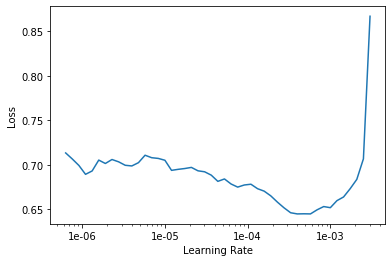

In [0]:
learn.recorder.plot()

In [0]:
learn.fit(2, 2e-4, wd=0.1)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.124720,0.130367,0.130367,02:10
1,0.126459,0.124989,0.124989,02:09


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


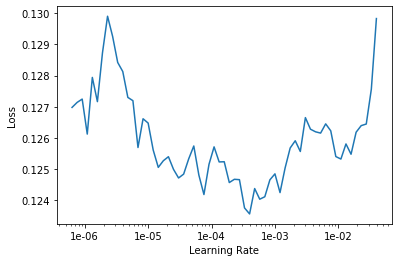

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit(2, 3e-4, wd=0.1)

epoch,train_loss,valid_loss,mean_squared_error,time
0,0.123804,0.124939,0.124939,01:33
1,0.126237,0.125087,0.125088,01:32


In [0]:
np.sqrt(0.124788)

0.3532534500893091

## Inference

In [0]:
#https://docs.fast.ai/tutorial.inference.html
preds = learn.get_preds(ds_type=DatasetType.Test)


In [0]:
#torch.sigmoid(preds[0])
preds[0].numpy().flatten(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  """Entry point for launching an IPython kernel.


array([0.470947, 0.49585 , 0.585449, 0.455566, ..., 0.529785, 0.468506, 0.535156, 0.500977], dtype=float32)

In [0]:
#valid_preds = gb_feat.build_predictions(valid[feature_names])
#print ("RMSE: %0.3f" %(np.sqrt(mean_squared_error(valid["target_kazutsugi"], valid_preds))))

In [0]:
#Sigmoid of the preds
"""
predictions = pd.DataFrame({"id":tournament_data.index, "prediction_kazutsugi": torch.sigmoid(preds[0])})
predictions[predictions['prediction_kazutsugi'] <= 0.0] = 0.01
predictions[predictions['prediction_kazutsugi'] >= 1.0] = 0.99
predictions.to_csv("/content/gdrive/My Drive/Numerai/output_NN.csv", index=False)
"""

In [0]:
predictions = pd.DataFrame({"id":tournament_data.index, "prediction_kazutsugi": preds[0].numpy().flatten(1)})
#predictions[predictions['prediction_kazutsugi'] <= 0.0] = 0.01
#predictions[predictions['prediction_kazutsugi'] >= 1.0] = 0.99
predictions.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
  """Entry point for launching an IPython kernel.


,id,prediction_kazutsugi
0,n0003aa52cab36c2,0.476318
1,n000920ed083903f,0.485840
2,n0038e640522c4a6,0.544922
3,n004ac94a87dc54b,0.474609
4,n0052fe97ea0c05f,0.514648


In [0]:
predictions.describe()

,prediction_kazutsugi
count,385452.000000
mean,0.499458
std,0.027172
min,0.322754
25%,0.484375
50%,0.499512
75%,0.516113
max,0.687988


In [0]:
predictions.to_csv("/content/gdrive/My Drive/Numerai/output_NN.csv", index=False)

In [0]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

class GradientBoostedFeatureGenerator(object):
    #TODO : Add in XGBoost/LightGBM instead of sklearn's GBC
    #TODO : Add in any learner, not necessarily LogReg ?
    #TODO : Enable enhanced functionality on the Train/Test split
    #TODO : Finish a Polynomial feature builder
    def __init__(self, X, y, nTrees=50, classification=True, build_poly=False):
        """
        Initialize our tree builder with the number of trees needed,
        X and y data to be trained on. We then randomly split the data,
        train the GradientBooster and Linear models. 
        
        The data input should be transformed already (e.g., scaling, encoding, ...)
        
        INPUTS:
        ------

        X : np.array() = Training features
        y : np.array() = Binary, 1-dimensional target vector
        nTrees: int = Number of trees to build our solution upon
        classification: Bool = Is our target variable 
        """
        from sklearn.model_selection import train_test_split
        
        assert(len(X)==len(y))
        assert(nTrees>=0)
        
        # We do not want to try to make any predictions if the models are not trained
        self.lin_built = False
        self.tree_built = False
        self.poly_built = False
        # Is our problem classification or regression?
        self.classification = classification
        self.build_poly = build_poly
        # Set our maximum number of trees
        self.nTrees = nTrees
        self.nLeaves = 50
        
        #42: The answer to life, the universe, everything...
        X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.5, random_state=42)
        
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test
        
        if self.build_poly:
            self._build_poly_features()
        
        self.gb_features = self.X_train.columns
        # Build our GradBoost and LogReg
        self._train_feature_trees()
        self._train_feature_lin()
        
    def _train_feature_trees(self):
        """
        Build our Gradient boosted model trained on 
        a portion of the input data
        """
        #from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier
        import lightgbm as lgb
        
        if self.classification:
            self.gb = lgb.LGBMClassifier(n_estimators=self.nTrees, num_leaves = self.nLeaves)
        else:
            self.gb = lgb.LGBMRegressor(n_estimators=self.nTrees, num_leaves = self.nLeaves)
            
        self.gb.fit(self.X_train, self.y_train)
        self.tree_built = True
        # If the user wants, you can get the trained tree
        return self.gb
    
    def _train_feature_lin(self):
        """
        Build our Linear on the remaining fraction of the input data.
        First, the features are generated
        """
        from sklearn.linear_model import LinearRegression,LogisticRegression
        
        # Instantiate a linear model
        if self.classification:
            self.lin = LogisticRegression(solver="lbfgs")
        else:
            self.lin = LinearRegression()
            
        # Build our features from the tree
        if self.tree_built:
            X_gen = self.build_features(self.X_test)
            #Train
            self.lin.fit(X_gen, self.y_test)
            self.lin_built = True
            # What columns are we returning?
            self.lin_feat_cols = X_gen.columns
        
        else:
            print("Error: You did not build a tree first")
        
        # If the user wants, you can get the trained linear model
        return self.lin
    
    def _build_poly_features(self):
        """
        Idea: Build a set of poly features, train a simple model,
            and then record top N of these features (10 perhaps?).
            
        Output: The top N features will then be saved and recreated for the 
                main training dataset with the Gradient Booster.
                
        On any large dataset, this breaks out in a `MemoryError`
        
        """
        import lightgbm as lgb
        
        if self.poly_built==False:
            if self.classification:
                gb = lgb.LGBMClassifier(n_estimators=10, num_leaves = self.nLeaves)
            else:
                gb = lgb.LGBMRegressor(n_estimators=10, num_leaves = self.nLeaves)
            
        gb.fit(training_data[feature_names], training_data["target_kazutsugi"])            
        self.top_features = [feature_names[idx] for idx in np.argsort(gb.feature_importances_)[::-1][:5]]

        
        for col1 in self.top_features:
            for col2 in self.top_features:
                if (col1+"|"+col2 not in self.X_train.columns) and (col2+"|"+col1 not in self.X_train.columns):
                    self.X_train[col1+"|"+col2] =  self.X_train[col1]*self.X_train[col2]
                    self.X_test[col1+"|"+col2] =  self.X_test[col1]*self.X_test[col2] 
                    
        self.poly_built = True
        
    def build_features(self, X_raw):
        """
        From the GBC's output, we dump out the index of the leaf nodes
        from each classifier
        
        INPUTS:
        ------
        X_raw: np.array() = Array of the same features as `X`, but new data
        
        """
        import pandas as pd
        
        if self.build_poly:
            for col1 in self.top_features:
                for col2 in self.top_features:
                    if (col1+"|"+col2 not in X_raw.columns) and (col2+"|"+col1 not in X_raw.columns):
                        X_raw[col1+"|"+col2] =  X_raw[col1]*X_raw[col2]
        # This gives us a np.array() of each tree's leaf index output
        leaf_node_output = self.gb.predict(X_raw[self.gb_features], pred_leaf=True)

        # Returns the leaf indices for each tree
        leaf_df = pd.DataFrame(leaf_node_output[:,:], 
                           columns=["leaf_index_tree"+str(n) for n in range(self.nTrees)])
        
        # Now we do a One-Hot of our leaf index to provide to our linear model
        self.leaf_df = pd.get_dummies(leaf_df.astype('category'),
                        prefix = ["OHE_"+str(col) for col in leaf_df.columns])
        
        # Sometimes the leaf indices never show up in the valid/test data, so fill with 0s
        if self.lin_built:
            for col in self.lin_feat_cols:
                if col not in self.leaf_df.columns:
                    self.leaf_df[col] = 0

            # Return same order column
            return self.leaf_df[self.lin_feat_cols]
        return self.leaf_df
    
    def build_predictions(self, X_input):
        """
        
        """
        if self.tree_built and self.lin_built:
            X_gen = self.build_features(X_input)
            # Either predict probabilities or real values
            if self.classification:
                y_prob = self.lin.predict_proba(X_gen)
            else: 
                y_prob = self.lin.predict(X_gen)
        
        #Return the scores
        return y_prob

        # 5 minutes for 50 trees and RMSE = 0.353, 21 minutes for 200 trees, 0.354 RMSE
gb_feat = GradientBoostedFeatureGenerator(training_data[feature_names], training_data["target_kazutsugi"], 
                                           nTrees=30, classification=False, build_poly=False)

valid_preds = gb_feat.build_predictions(valid[feature_names])
print ("RMSE: %0.3f" %(np.sqrt(mean_squared_error(valid["target_kazutsugi"], valid_preds))))

preds = gb_feat.build_predictions(tournament_data[feature_names])
preds

predictions = pd.DataFrame({"id":tournament_data.index, "prediction_kazutsugi": preds})
#predictions[predictions["prediction_kazutsugi"] <= 0.] = 0.01
#predictions[predictions["prediction_kazutsugi"] >= 1.] = 0.85


RMSE: 0.354


In [0]:
predictions.to_csv("/content/gdrive/My Drive/Numerai/outputMoreLeaves_noPoly.csv", index=False)